In [3]:
import sys
sys.path.append("..")


from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


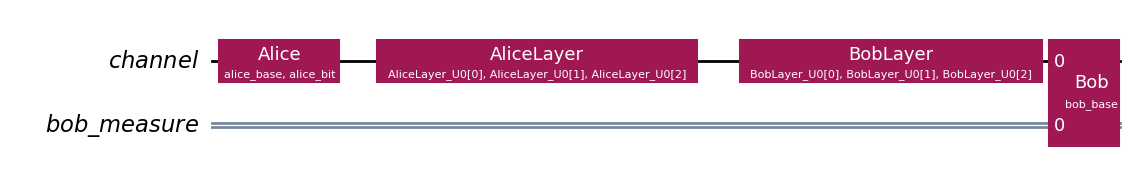

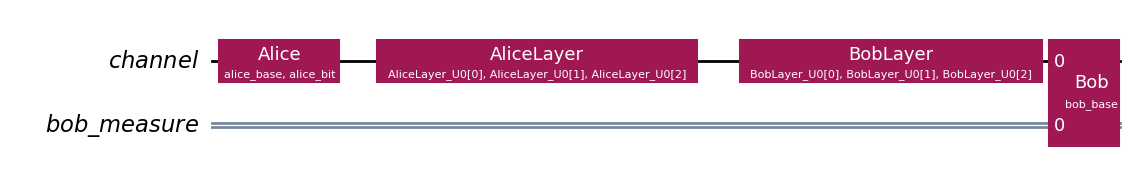

In [4]:
layers = [SeparableLayer("AliceLayer"), SeparableLayer("BobLayer")]
eve = MultiQubitQCLEve()

ab_protocol = BB84TrainableProtocol(n_bits=512, elements=layers, channel_size=1, seed=0, learning_rate=0.1)
eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=[layers[0], eve, layers[1]], channel_size=1,
                                        seed=0, alpha=1, learning_rate=0.1)

qc, _ = ab_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [5]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0 or epoch == 49:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

def train_ab():
    bob_qber, eve_qber = [], []
    qber = ab_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(0.5)
    print(f'start QBER: {qber}')
    for epoch in range(20):
        loss = ab_protocol.train()
        qber = ab_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(0.5)
        if epoch % 5 == 0 or epoch == 19:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

# Krok 1 - trenowanie Alice i Boba do początkowego stanu
Uczymy Alice i Boba bez Eve, aby miały sensowne parametry początkowe i potrafiły przekazywać sobie dane.

In [6]:
b_q, e_q = train_ab()

start QBER: {'bob_qber': np.float64(0.3650793650793651)}
epoch: 0, loss: -0.7077720165252686, QBER: {'bob_qber': np.float64(0.25396825396825395)}
epoch: 5, loss: -0.974007248878479, QBER: {'bob_qber': np.float64(0.011904761904761862)}
epoch: 10, loss: -0.9887076020240784, QBER: {'bob_qber': np.float64(0.007936507936507908)}
epoch: 15, loss: -0.9927444458007812, QBER: {'bob_qber': np.float64(0.003968253968253954)}
epoch: 19, loss: -0.992146372795105, QBER: {'bob_qber': np.float64(0.003968253968253954)}


<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

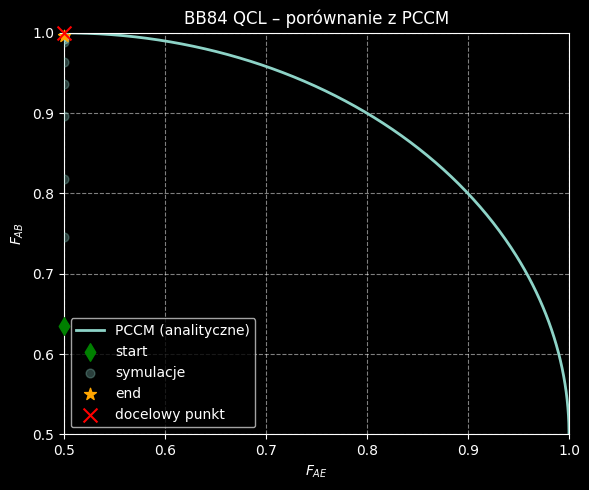

In [7]:
plt_fab_fae(b_q, e_q, 1)

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8. Startujemy od parametrów Alice i Boba wytrenowanych w poprzednim kroku i Eve jako identyczność.

In [8]:
eve_protocol.set_parameters(ab_protocol.get_all_parameters())

params = eve_protocol.get_all_parameters()
for p in eve.trainable_parameters():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'NU_W_U0[0]': np.float32(0.0), 'NU_W_U0[1]': np.float32(0.0), 'NU_W_U0[2]': np.float32(0.0), 'NU_W_U1[0]': np.float32(0.0), 'NU_W_U1[1]': np.float32(0.0), 'NU_W_U1[2]': np.float32(0.0), 'NU_W_weyl[0]': np.float32(0.0), 'NU_W_weyl[1]': np.float32(0.0), 'NU_W_weyl[2]': np.float32(0.0), 'ΛZ[0]': np.float32(0.0), 'ΛZ[1]': np.float32(0.0), 'ΛZ[2]': np.float32(0.0), 'ΛX[0]': np.float32(0.0), 'ΛX[1]': np.float32(0.0), 'ΛX[2]': np.float32(0.0)}
Frozen parameters: {'AliceLayer_U0[0]': np.float32(0.41773745), 'AliceLayer_U0[1]': np.float32(1.5007838), 'AliceLayer_U0[2]': np.float32(-1.8390158), 'BobLayer_U0[0]': np.float32(0.22658098), 'BobLayer_U0[1]': np.float32(-0.8056277), 'BobLayer_U0[2]': np.float32(1.205482)}


In [9]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.007352941176470562), 'eve_qber': np.float64(0.5294117647058824)}
epoch: 0, loss: -0.980063259601593, QBER: {'bob_qber': np.float64(0.014705882352941124), 'eve_qber': np.float64(0.5294117647058824)}
epoch: 5, loss: -0.9879035949707031, QBER: {'bob_qber': np.float64(0.007352941176470562), 'eve_qber': np.float64(0.5330882352941176)}
epoch: 10, loss: -0.9815698862075806, QBER: {'bob_qber': np.float64(0.003676470588235281), 'eve_qber': np.float64(0.5294117647058824)}
epoch: 15, loss: -0.9950826168060303, QBER: {'bob_qber': np.float64(0.007352941176470562), 'eve_qber': np.float64(0.5257352941176471)}
epoch: 20, loss: -1.0175085067749023, QBER: {'bob_qber': np.float64(0.0404411764705882), 'eve_qber': np.float64(0.4117647058823529)}
epoch: 25, loss: -1.0417572259902954, QBER: {'bob_qber': np.float64(0.03676470588235292), 'eve_qber': np.float64(0.375)}
epoch: 30, loss: -1.0564982891082764, QBER: {'bob_qber': np.float64(0.03308823529411764), 'eve_qber': np.f

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

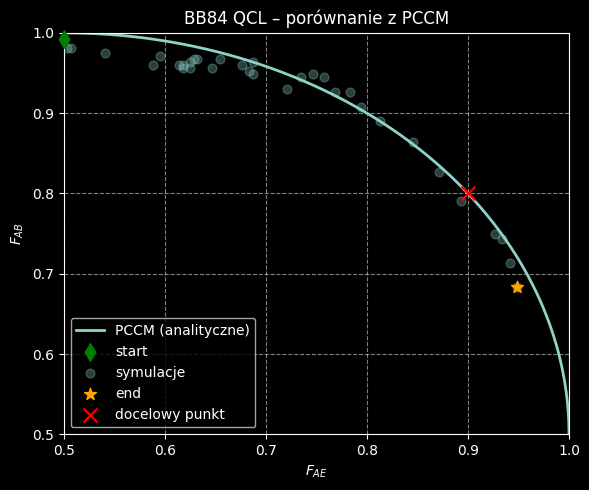

In [10]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [11]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'AliceLayer_U0[0]': np.float32(0.41773745), 'AliceLayer_U0[1]': np.float32(1.5007838), 'AliceLayer_U0[2]': np.float32(-1.8390158), 'BobLayer_U0[0]': np.float32(0.22658098), 'BobLayer_U0[1]': np.float32(-0.8056277), 'BobLayer_U0[2]': np.float32(1.205482)}
Frozen parameters: {'NU_W_U0[0]': np.float32(-0.6001331), 'NU_W_U0[1]': np.float32(0.05470402), 'NU_W_U0[2]': np.float32(-0.110841215), 'NU_W_U1[0]': np.float32(1.425619), 'NU_W_U1[1]': np.float32(-1.4629349), 'NU_W_U1[2]': np.float32(-5.830694e-09), 'NU_W_weyl[0]': np.float32(1.1875561), 'NU_W_weyl[1]': np.float32(-0.3612648), 'NU_W_weyl[2]': np.float32(1.1644562), 'ΛZ[0]': np.float32(-0.3784376), 'ΛZ[1]': np.float32(-0.41527128), 'ΛZ[2]': np.float32(-1.0144451), 'ΛX[0]': np.float32(1.4819282), 'ΛX[1]': np.float32(-0.42654526), 'ΛX[2]': np.float32(1.9249761)}


/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [12]:
eve_loss = eve_protocol.loss
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.3161764705882353), 'eve_qber': np.float64(0.05147058823529416)}
epoch: 0, loss: -0.688774824142456, QBER: {'bob_qber': np.float64(0.2867647058823529), 'eve_qber': np.float64(0.047794117647058876)}
epoch: 5, loss: -0.6935443878173828, QBER: {'bob_qber': np.float64(0.2683823529411765), 'eve_qber': np.float64(0.0625)}
epoch: 10, loss: -0.6993757486343384, QBER: {'bob_qber': np.float64(0.2720588235294118), 'eve_qber': np.float64(0.0625)}
epoch: 15, loss: -0.6965955495834351, QBER: {'bob_qber': np.float64(0.2647058823529411), 'eve_qber': np.float64(0.06617647058823528)}
epoch: 20, loss: -0.7029845714569092, QBER: {'bob_qber': np.float64(0.2720588235294118), 'eve_qber': np.float64(0.06617647058823528)}
epoch: 25, loss: -0.696974515914917, QBER: {'bob_qber': np.float64(0.27941176470588236), 'eve_qber': np.float64(0.06985294117647056)}
epoch: 30, loss: -0.6997207403182983, QBER: {'bob_qber': np.float64(0.2647058823529411), 'eve_qber': np.float64(0.07720588

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

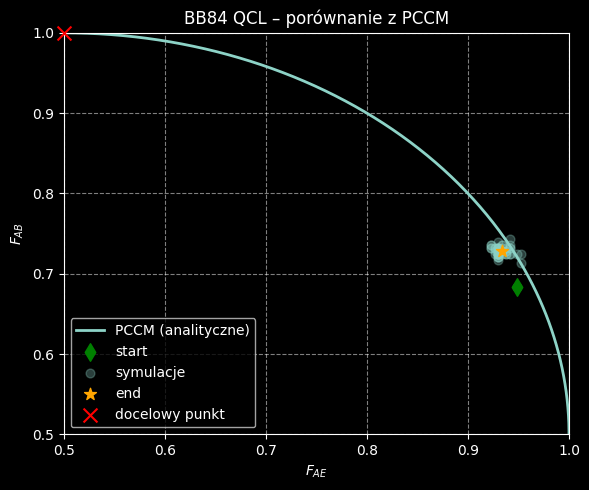

In [13]:
plt_fab_fae(b_q, e_q, 1)

In [14]:
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'NU_W_U0[0]': np.float32(-0.6001331), 'NU_W_U0[1]': np.float32(0.05470402), 'NU_W_U0[2]': np.float32(-0.110841215), 'NU_W_U1[0]': np.float32(1.425619), 'NU_W_U1[1]': np.float32(-1.4629349), 'NU_W_U1[2]': np.float32(-5.830694e-09), 'NU_W_weyl[0]': np.float32(1.1875561), 'NU_W_weyl[1]': np.float32(-0.3612648), 'NU_W_weyl[2]': np.float32(1.1644562), 'ΛZ[0]': np.float32(-0.3784376), 'ΛZ[1]': np.float32(-0.41527128), 'ΛZ[2]': np.float32(-1.0144451), 'ΛX[0]': np.float32(1.4819282), 'ΛX[1]': np.float32(-0.42654526), 'ΛX[2]': np.float32(1.9249761)}
Frozen parameters: {'AliceLayer_U0[0]': np.float32(0.39042166), 'AliceLayer_U0[1]': np.float32(0.66311884), 'AliceLayer_U0[2]': np.float32(-0.90952766), 'BobLayer_U0[0]': np.float32(-0.085386656), 'BobLayer_U0[1]': np.float32(-0.8101477), 'BobLayer_U0[2]': np.float32(0.8568525)}


/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [15]:
eve_protocol.f_value = 0.8
eve_protocol.loss = eve_loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.2720588235294118), 'eve_qber': np.float64(0.06617647058823528)}
epoch: 0, loss: -1.1561824083328247, QBER: {'bob_qber': np.float64(0.2536764705882353), 'eve_qber': np.float64(0.0845588235294118)}
epoch: 5, loss: -1.1942708492279053, QBER: {'bob_qber': np.float64(0.18382352941176472), 'eve_qber': np.float64(0.12867647058823528)}
epoch: 10, loss: -1.2276735305786133, QBER: {'bob_qber': np.float64(0.20220588235294112), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 15, loss: -1.1905475854873657, QBER: {'bob_qber': np.float64(0.21691176470588236), 'eve_qber': np.float64(0.09558823529411764)}
epoch: 20, loss: -1.2034310102462769, QBER: {'bob_qber': np.float64(0.2095588235294118), 'eve_qber': np.float64(0.09558823529411764)}
epoch: 25, loss: -1.2140268087387085, QBER: {'bob_qber': np.float64(0.2095588235294118), 'eve_qber': np.float64(0.09926470588235292)}
epoch: 30, loss: -1.2026575803756714, QBER: {'bob_qber': np.float64(0.1875), 'eve_qber': np.fl

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

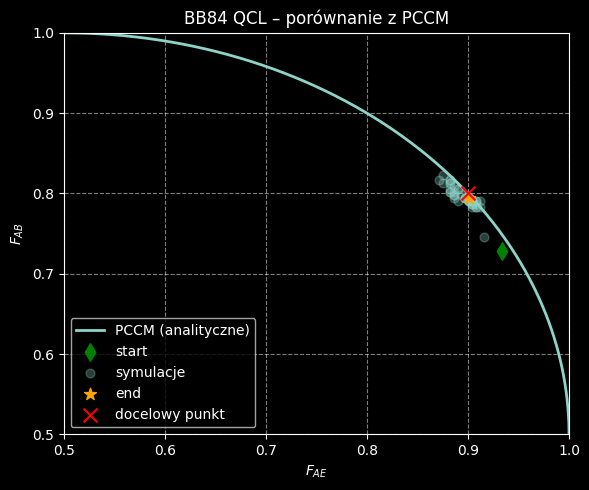

In [16]:
plt_fab_fae(b_q, e_q, 0.8)

In [17]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'AliceLayer_U0[0]': np.float32(0.39042166), 'AliceLayer_U0[1]': np.float32(0.66311884), 'AliceLayer_U0[2]': np.float32(-0.90952766), 'BobLayer_U0[0]': np.float32(-0.085386656), 'BobLayer_U0[1]': np.float32(-0.8101477), 'BobLayer_U0[2]': np.float32(0.8568525)}
Frozen parameters: {'NU_W_U0[0]': np.float32(-0.53037596), 'NU_W_U0[1]': np.float32(0.1776614), 'NU_W_U0[2]': np.float32(-0.07796982), 'NU_W_U1[0]': np.float32(1.4550606), 'NU_W_U1[1]': np.float32(-1.3955424), 'NU_W_U1[2]': np.float32(-4.4391273e-09), 'NU_W_weyl[0]': np.float32(0.9451373), 'NU_W_weyl[1]': np.float32(-0.31219098), 'NU_W_weyl[2]': np.float32(0.9217846), 'ΛZ[0]': np.float32(-0.52514434), 'ΛZ[1]': np.float32(-0.29676425), 'ΛZ[2]': np.float32(-1.1494128), 'ΛX[0]': np.float32(1.3272518), 'ΛX[1]': np.float32(-0.19296977), 'ΛX[2]': np.float32(1.7592314)}


/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [18]:
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.20588235294117652), 'eve_qber': np.float64(0.09926470588235292)}
epoch: 0, loss: -0.7971434593200684, QBER: {'bob_qber': np.float64(0.19485294117647056), 'eve_qber': np.float64(0.10661764705882348)}
epoch: 5, loss: -0.7987177968025208, QBER: {'bob_qber': np.float64(0.19117647058823528), 'eve_qber': np.float64(0.1029411764705882)}
epoch: 10, loss: -0.8012917637825012, QBER: {'bob_qber': np.float64(0.20588235294117652), 'eve_qber': np.float64(0.1029411764705882)}
epoch: 15, loss: -0.7981286644935608, QBER: {'bob_qber': np.float64(0.20220588235294112), 'eve_qber': np.float64(0.09926470588235292)}
epoch: 20, loss: -0.794904351234436, QBER: {'bob_qber': np.float64(0.20220588235294112), 'eve_qber': np.float64(0.1029411764705882)}
epoch: 25, loss: -0.7988472580909729, QBER: {'bob_qber': np.float64(0.20220588235294112), 'eve_qber': np.float64(0.09926470588235292)}
epoch: 30, loss: -0.8045246005058289, QBER: {'bob_qber': np.float64(0.20220588235294112), 'ev

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

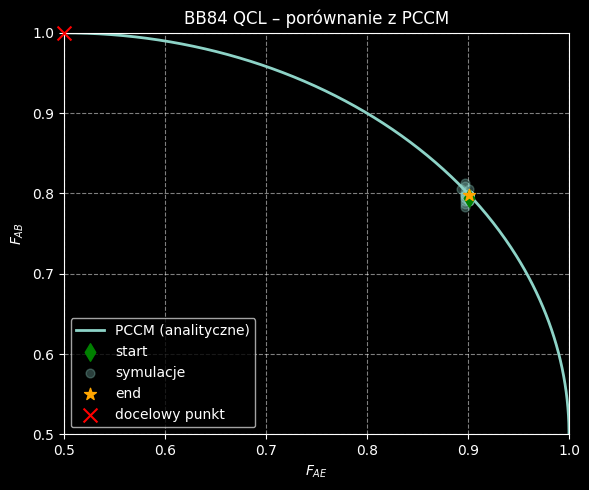

In [19]:
plt_fab_fae(b_q, e_q, 1)

In [20]:
print("All parameters:", eve_protocol.get_all_parameters())

All parameters: {'NU_W_U0[0]': np.float32(-0.53037596), 'NU_W_U0[1]': np.float32(0.1776614), 'NU_W_U0[2]': np.float32(-0.07796982), 'NU_W_U1[0]': np.float32(1.4550606), 'NU_W_U1[1]': np.float32(-1.3955424), 'NU_W_U1[2]': np.float32(-4.4391273e-09), 'NU_W_weyl[0]': np.float32(0.9451373), 'NU_W_weyl[1]': np.float32(-0.31219098), 'NU_W_weyl[2]': np.float32(0.9217846), 'ΛZ[0]': np.float32(-0.52514434), 'ΛZ[1]': np.float32(-0.29676425), 'ΛZ[2]': np.float32(-1.1494128), 'ΛX[0]': np.float32(1.3272518), 'ΛX[1]': np.float32(-0.19296977), 'ΛX[2]': np.float32(1.7592314), 'AliceLayer_U0[0]': np.float32(0.3941871), 'AliceLayer_U0[1]': np.float32(0.715155), 'AliceLayer_U0[2]': np.float32(-0.9670007), 'BobLayer_U0[0]': np.float32(-0.0716011), 'BobLayer_U0[1]': np.float32(-0.7835513), 'BobLayer_U0[2]': np.float32(0.84954655)}


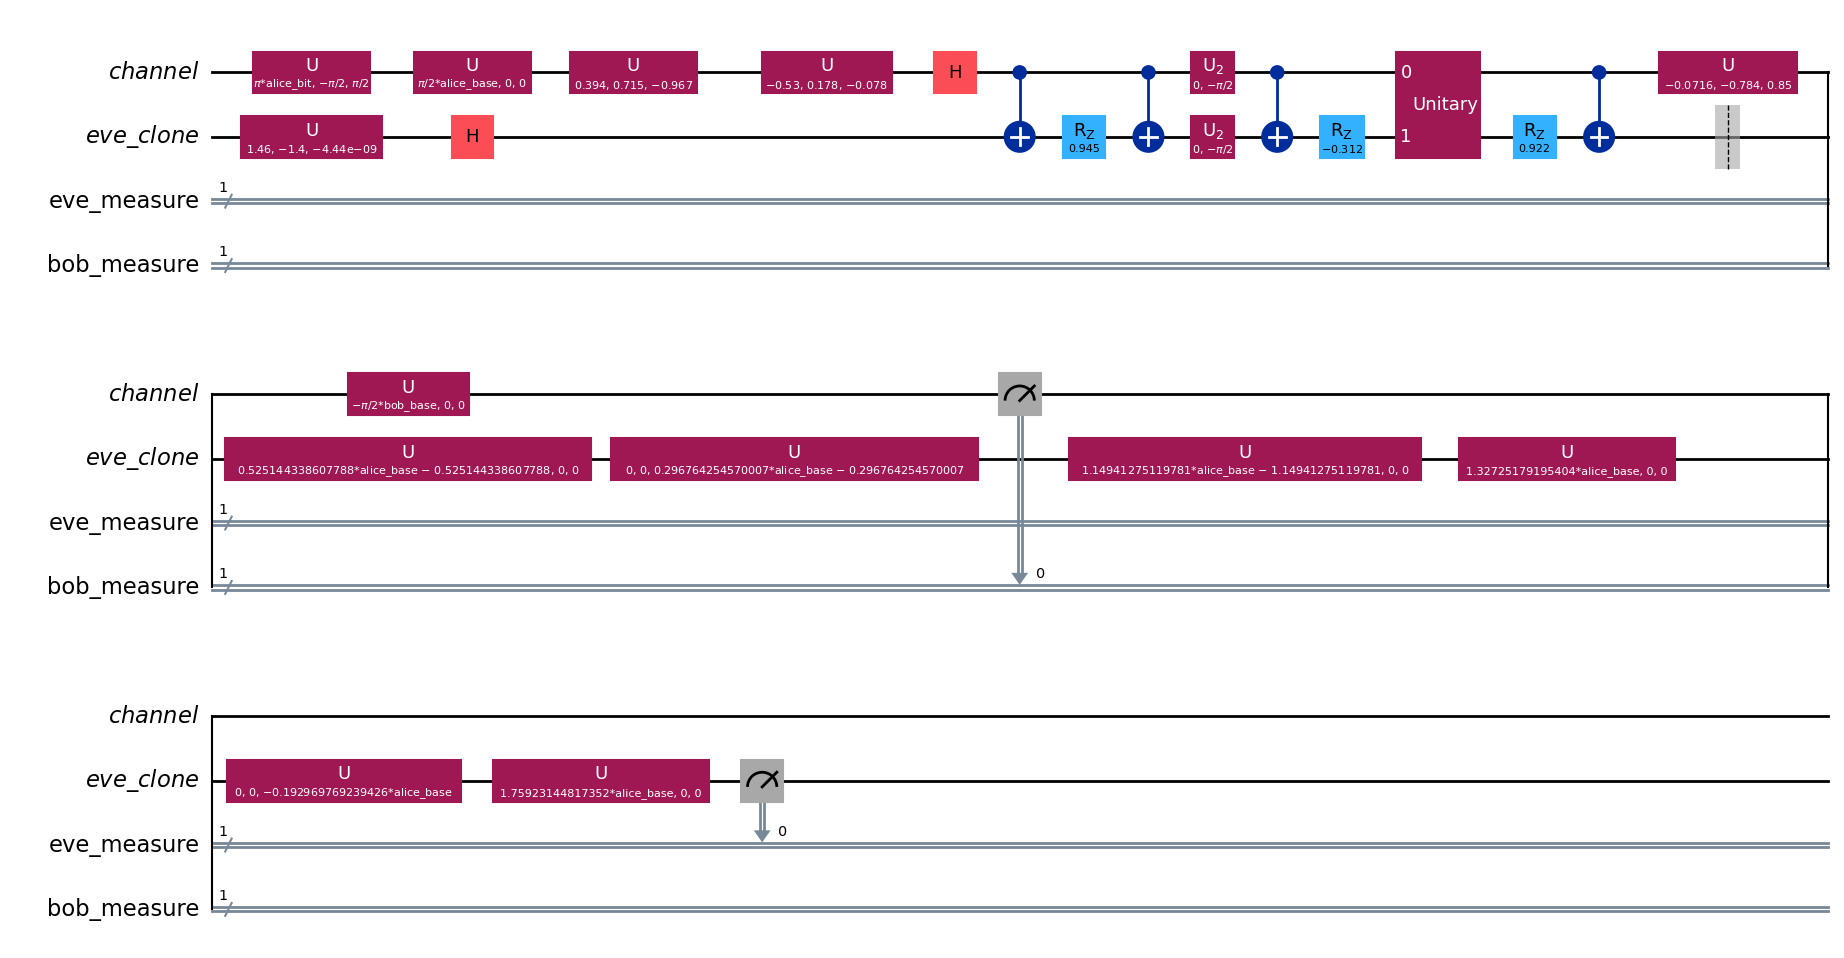

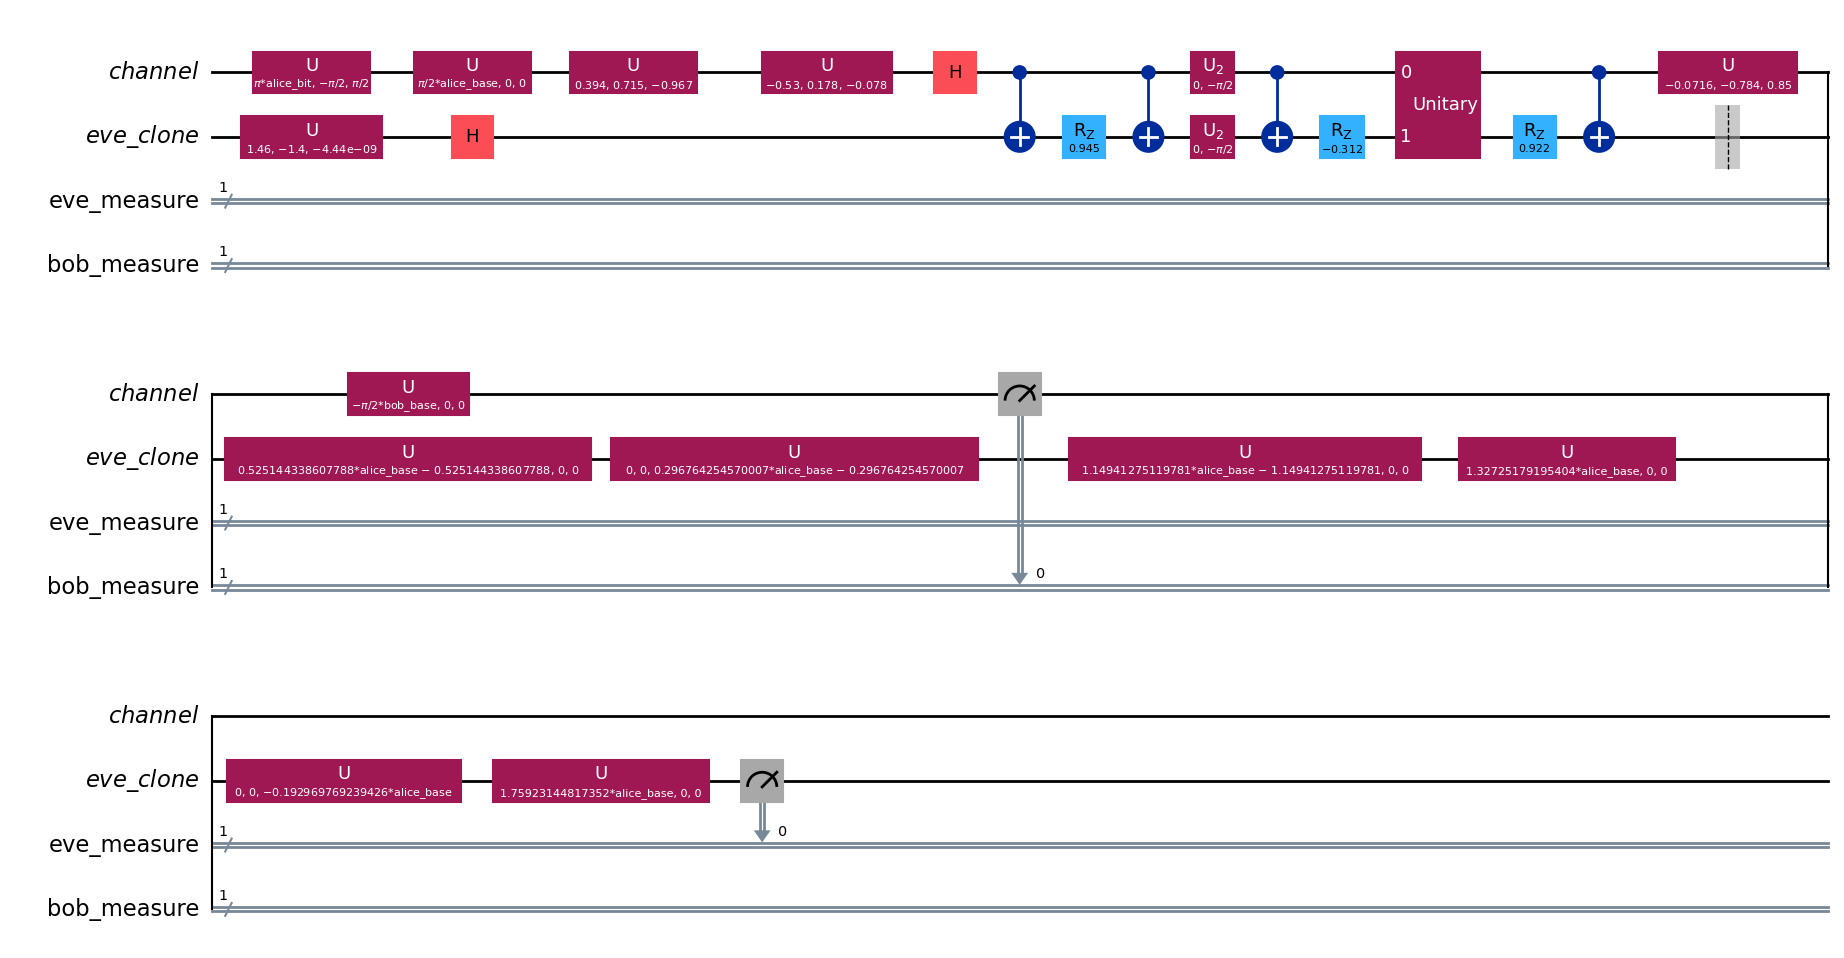

In [21]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")